# CMX Sky Surface Brightness
So far I've been estimating the sky flux by applying flux correction to the `sky` data. This however overestimates the sky since it includes the (transparency) and (fiber fraction) within the flux calibration. 

$(\mathtt{sky~surface~brightness}) = (\mathtt{sky~data})/(\mathtt{throughput})/(\mathtt{photons~per~bin})/(\mathtt{exp.~time})/(\mathtt{fiber~area})$

where $(\mathtt{sky~data})$ is the flat fielded sky fiber data

In [1]:
import os
import fitsio
import numpy as np 
from scipy.signal import medfilt

import astropy.units as u
import astropy.constants as const

from specsim.simulator import Simulator 

import desisim.simexp
import specsim.instrument
from desispec.io import read_sky
from desispec.io import read_frame
from desimodel.io import load_throughput

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
tileid = 70502
date = 20200225
expid = 52113
ispec = 0 

dir_redux = "/global/cfs/cdirs/desi/spectro/redux/daily" 
dir_coadd = '/global/cfs/cdirs/desi/users/chahah/bgs_exp_coadd/'

In [4]:
wavemin = load_throughput('b').wavemin - 10.0
wavemax = load_throughput('z').wavemax + 10.0
wave = np.arange(round(wavemin, 1), wavemax, 0.8) * u.Angstrom

# Generate specsim config object for a given wavelength grid
config = desisim.simexp._specsim_config_for_wave(wave.to('Angstrom').value, dwave_out=0.8, specsim_config_file='desi')

In [5]:
desi = Simulator(config, num_fibers=1)
instrument = specsim.instrument.initialize(config, True)

In [6]:
nominal_surface_brightness_dict = config.load_table(config.atmosphere.sky, 'surface_brightness', as_dict=True)

In [7]:
f_sky = lambda band: os.path.join(dir_redux, 'exposures', str(date), str(expid).zfill(8), 
                                  'sky-%s%i-%s.fits' % (band, ispec, str(expid).zfill(8)))
sky_b = read_sky(f_sky('b'))
sky_r = read_sky(f_sky('r'))
sky_z = read_sky(f_sky('z'))

In [8]:
exptime = sky_b.header['EXPTIME']

# convert to surface brightness

In [9]:
plate_scale = config.load_table(config.instrument.plate_scale, ['radius', 'radial_scale', 'azimuthal_scale'], interpolate=False)
radial_fiber_size = (0.5 * instrument.fiber_diameter / instrument.radial_scale(plate_scale['radius']))
azimuthal_fiber_size = (0.5 * instrument.fiber_diameter / instrument.azimuthal_scale(plate_scale['radius']))

mean_fiber_area = np.mean(np.pi*radial_fiber_size * azimuthal_fiber_size)

In [10]:
print('mean fiber area = %f' % mean_fiber_area.value)

mean fiber area = 1.862089


In [11]:
sbunit = desi.atmosphere.surface_brightness.unit
def convert_sky_rate(inc):
    # The incident rate is in phot per 0.8A wavelength bin.
    # Convert to surface brightness units (sbunit) suitable as input to specsim.
    wave = inc.wave * u.Angstrom
    dwave = np.gradient(wave)
    
    ephot = (const.h * const.c / wave / u.ph).to(u.erg / u.ph)
    etendue = (instrument.effective_area * mean_fiber_area).to(u.cm ** 2 * u.arcsec ** 2)
    
    # Calculate surface brightness on the 0.8A reduction grid.
    surfbrightness = ((inc.flux * u.ph / (exptime * u.s)) / dwave * ephot / etendue).to(sbunit)
    
    # Upsample to 0.1A specsim simulation grid. This means that resolution will be reapplied by specsim, but
    # should at least give the correct normalization and smoothed shape. Because we are upsampling a density,
    # no rescaling for the new bin size is required. The result will be padded to the wider simulation grid
    # by repeating the first and last values.
    return surfbrightness #np.interp(simwave, inc.wave, surfbrightness.data) * sbunit

In [12]:
sky_sb_b = convert_sky_rate(sky_b)
sky_sb_r = convert_sky_rate(sky_r)
sky_sb_z = convert_sky_rate(sky_z)

In [13]:
through_b = load_throughput('b').hardware_throughput(sky_b.wave)
through_r = load_throughput('r').hardware_throughput(sky_r.wave)
through_z = load_throughput('z').hardware_throughput(sky_z.wave)

# correct for throughput

(0.0, 1)

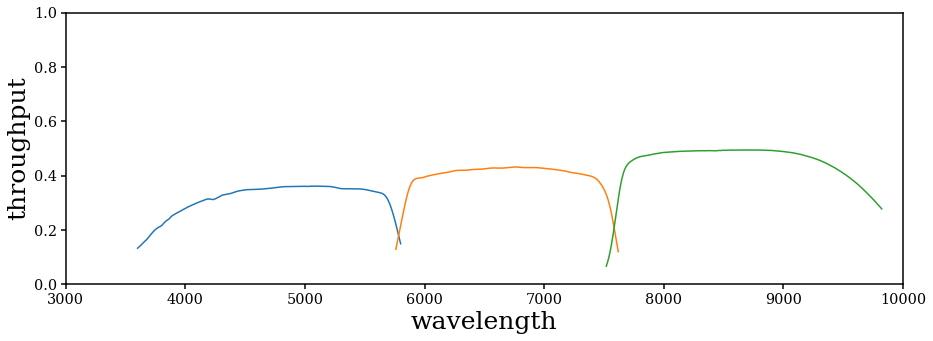

In [14]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
#for camera in instrument.cameras: 
#    sub.plot(wave, camera.throughput)
sub.plot(sky_b.wave, through_b)
sub.plot(sky_r.wave, through_r)
sub.plot(sky_z.wave, through_z)
sub.set_xlabel('wavelength', fontsize=25)
sub.set_xlim(3e3, 1e4)
sub.set_ylabel('throughput', fontsize=25)
sub.set_ylim(0., 1)

(0.0, 2.0)

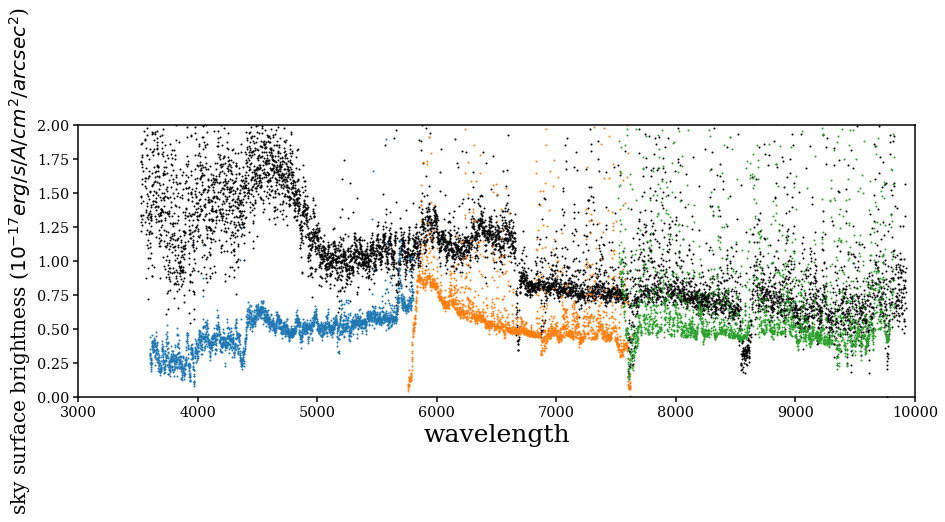

In [15]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)

sub.scatter(wave.value, nominal_surface_brightness_dict['dark'].value, s=1, c='k', label='nominal dark')

sub.scatter(sky_b.wave, np.median(sky_sb_b, axis=0)/through_b, s=1)
sub.scatter(sky_r.wave, np.median(sky_sb_r, axis=0)/through_r, s=1)
sub.scatter(sky_z.wave, np.median(sky_sb_z, axis=0)/through_z, s=1)

sub.set_xlabel('wavelength', fontsize=25)
sub.set_xlim(3e3, 1e4)
sub.set_ylabel('sky surface brightness ($10^{-17} erg/s/A/cm^2/arcsec^2$)', fontsize=20)
sub.set_ylim(0.,2.)

This is consistent with what I was doing before except there was **a bug with the wavelength resolution**!

In [16]:
med_sky_b_smooth = np.interp(wave, sky_b.wave, medfilt(sky_b.flux[0,:], 301))
med_sky_b_smooth[(wave.value < sky_b.wave.min()) | (wave.value > sky_b.wave.max())] = 0.

med_sky_r_smooth = np.interp(wave, sky_r.wave, medfilt(sky_r.flux[0,:], 301))
med_sky_r_smooth[(wave.value < sky_r.wave.min()) | (wave.value > sky_r.wave.max())] = 0.

med_sky_z_smooth = np.interp(wave, sky_z.wave, medfilt(sky_z.flux[0,:], 301))
med_sky_z_smooth[(wave.value < sky_z.wave.min()) | (wave.value > sky_z.wave.max())] = 0.

/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in true_divide


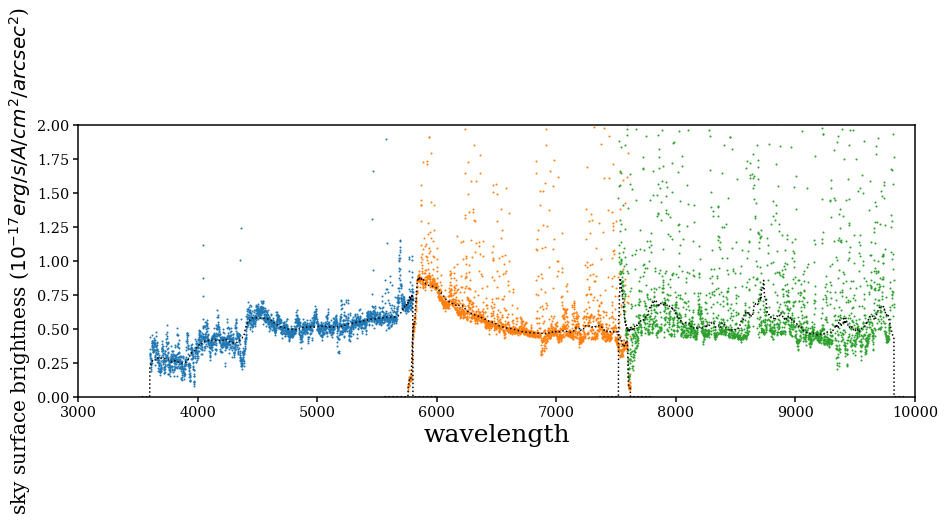

In [17]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)

sub.scatter(sky_b.wave, np.median(sky_sb_b, axis=0)/through_b, s=1)
sub.scatter(sky_r.wave, np.median(sky_sb_r, axis=0)/through_r, s=1)
sub.scatter(sky_z.wave, np.median(sky_sb_z, axis=0)/through_z, s=1)

sub.set_xlabel('wavelength', fontsize=25)
sub.set_xlim(3e3, 1e4)
sub.set_ylabel('sky surface brightness ($10^{-17} erg/s/A/cm^2/arcsec^2$)', fontsize=20)
sub.set_ylim(0.,2.)
for i,_sky in enumerate([med_sky_b_smooth, med_sky_r_smooth, med_sky_z_smooth]): 
    sky_bright = _sky / instrument.cameras[i].throughput / instrument.photons_per_bin / exptime / mean_fiber_area * 1e17
    sub.plot(wave, sky_bright, c='k', ls=':')